In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

## Device

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

## Load DinoV2

In [3]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\bruno/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\bruno/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\bruno/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\bruno/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## Visualize

In [4]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)
patch_size = dinov2_vits14.patch_size

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vitl14

In [5]:
transform1 = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

In [6]:
total_features  = []
ROOT_PATH = 'imagens/'

folder_path = f'{ROOT_PATH}/train/ABBOTTS BABBLER/'
with torch.no_grad():
  list_img_path = os.listdir(folder_path)[0:4]
  for img_path in list_img_path:
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img).to(device)
    
    features_dict = dinov2_vits14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 384])

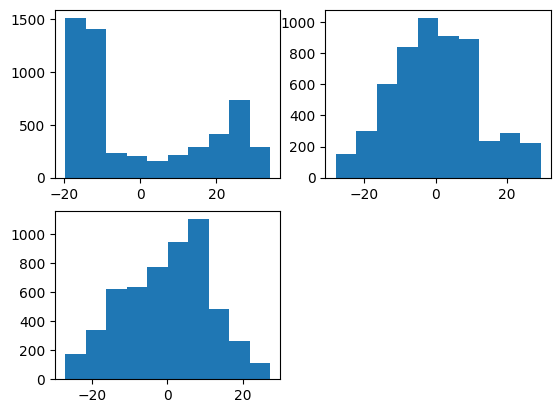

In [7]:
# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

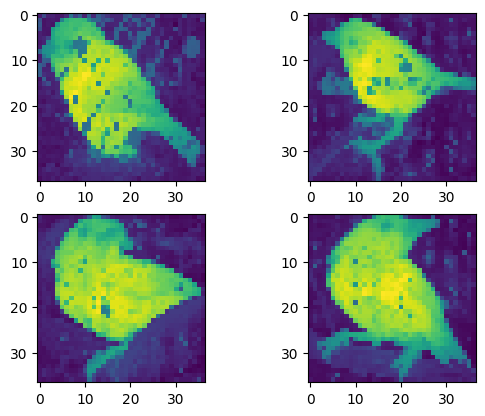

In [8]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

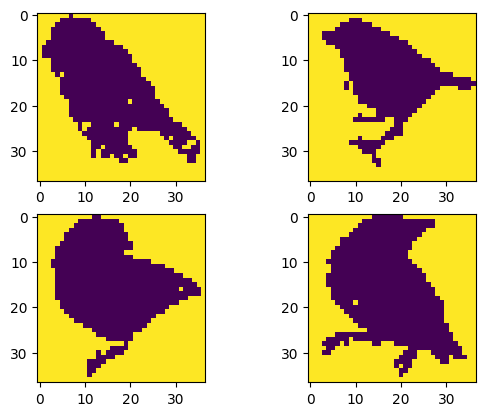

In [9]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] < 0.4 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


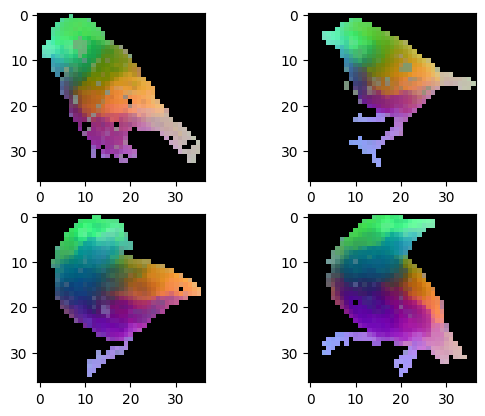

In [10]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()


## Prepare Dataset

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(ROOT_PATH, x), data_transforms[x]) 
    for x in ['train', 'test']
}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3208
     Root location: imagens/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 100
     Root location: imagens/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [13]:
batch_size = 8
num_workers = 4

data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=4)
    for x in ['train', 'test']
}

In [14]:
class_names = image_datasets['train'].classes
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

## Model

In [15]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x
    
model = DinoVisionTransformerClassifier()
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

## Train

In [17]:
num_epoch = 10
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(data_loaders['train'])
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

Epoch [9/10]: 100%|██████████| 401/401 [00:18<00:00, 21.52it/s, acc=1, loss=0.0793]   


## Test

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to('cuda')
        labels = labels.to('cuda')

        # calculate outputs by running images through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels).sum().item()
        
        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(data_loaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 78 test images: 100 %


## Report

In [19]:
print(classification_report(test_labels, test_predicted, target_names=class_names))


                            precision    recall  f1-score   support

           ABBOTTS BABBLER       1.00      1.00      1.00         5
             ABBOTTS BOOBY       1.00      1.00      1.00         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                 ALBATROSS       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
     ALTAMIRA YELLOWTHROAT       1.00      1.00

In [20]:
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm, 
    index = class_names,
    columns = class_names
)
df_cm

,ABBOTTS BABBLER,ABBOTTS BOOBY,ABYSSINIAN GROUND HORNBILL,AFRICAN CROWNED CRANE,AFRICAN EMERALD CUCKOO,AFRICAN FIREFINCH,AFRICAN OYSTER CATCHER,AFRICAN PIED HORNBILL,AFRICAN PYGMY GOOSE,ALBATROSS,ALBERTS TOWHEE,ALEXANDRINE PARAKEET,ALPINE CHOUGH,ALTAMIRA YELLOWTHROAT,AMERICAN AVOCET,AMERICAN BITTERN,AMERICAN COOT,AMERICAN FLAMINGO,AMERICAN GOLDFINCH,AMERICAN KESTREL
ABBOTTS BABBLER,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABBOTTS BOOBY,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABYSSINIAN GROUND HORNBILL,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN CROWNED CRANE,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN EMERALD CUCKOO,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN FIREFINCH,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN OYSTER CATCHER,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN PIED HORNBILL,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
AFRICAN PYGMY GOOSE,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0
ALBATROSS,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


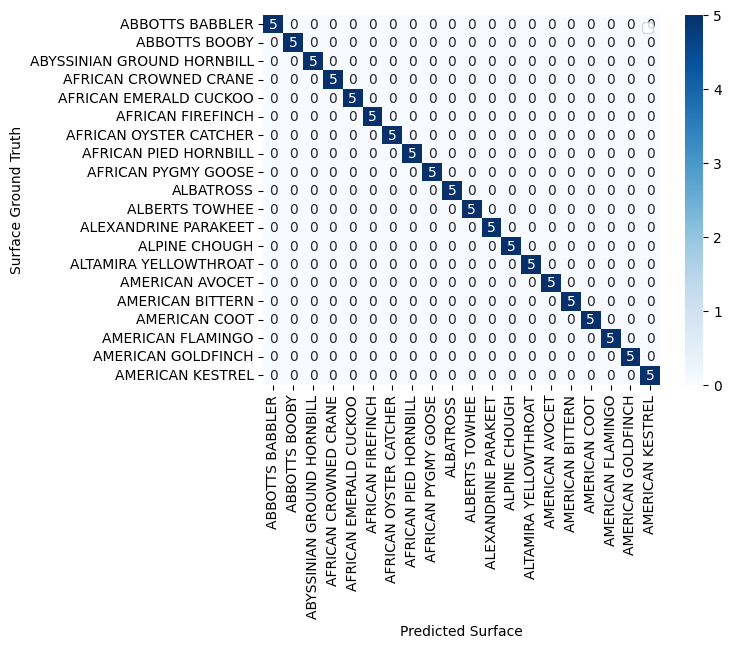

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)